<a href="https://colab.research.google.com/github/bcramp/GenAI/blob/main/HW1/LLM_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How an LLM Generates Text**

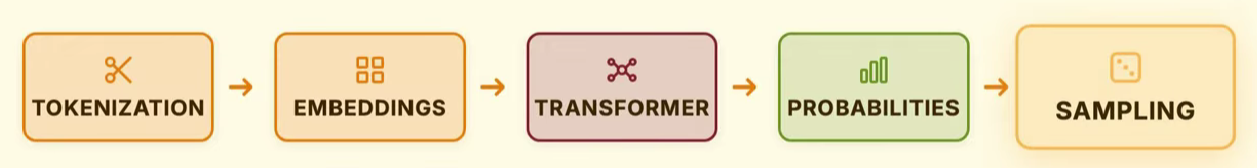

In [ ]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao



# **torch**

This is **PyTorch**, the deep learning framework. It contains support for:

* Tensors, which are similar to nD arrays but much faster with GPU support
* Neural network layers
* GPU acceleration, when/if available
* LLMs, which cannot run without libraries such as PyTorch

# **transformers**

* The Hugging Face Transformers library contains:
  * Pretrained models such as GPT-2, BERT, etc.
  * Tokenizers
  * Model architectures
  * Loading & inference APIs
  * Without this library, we  would have to implement the transformer architecture, load model weights manually, write tokenizers from scratch, etc.

In [ ]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT


In [ ]:
# Load tokenizer & model

# GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Distillation GPT-2 model (extra credit)
# tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
# model = GPT2LMHeadModel.from_pretrained("distilgpt2")

model.eval()


In [ ]:
# Enter your own input text

# Example: I want to travel the world. I will go
text = input("Enter a sentence: ")


In [ ]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")


In [ ]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)


In [ ]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)


In [ ]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)



# **Softmax and Probabilities**

* In LLMs, the output layer spans the entire vocabulary.
* In a traditional classification model predicts the class with the highest softmax score, which makes it deterministic.

* But LLMs sample the prediction from these softmax probabilities:

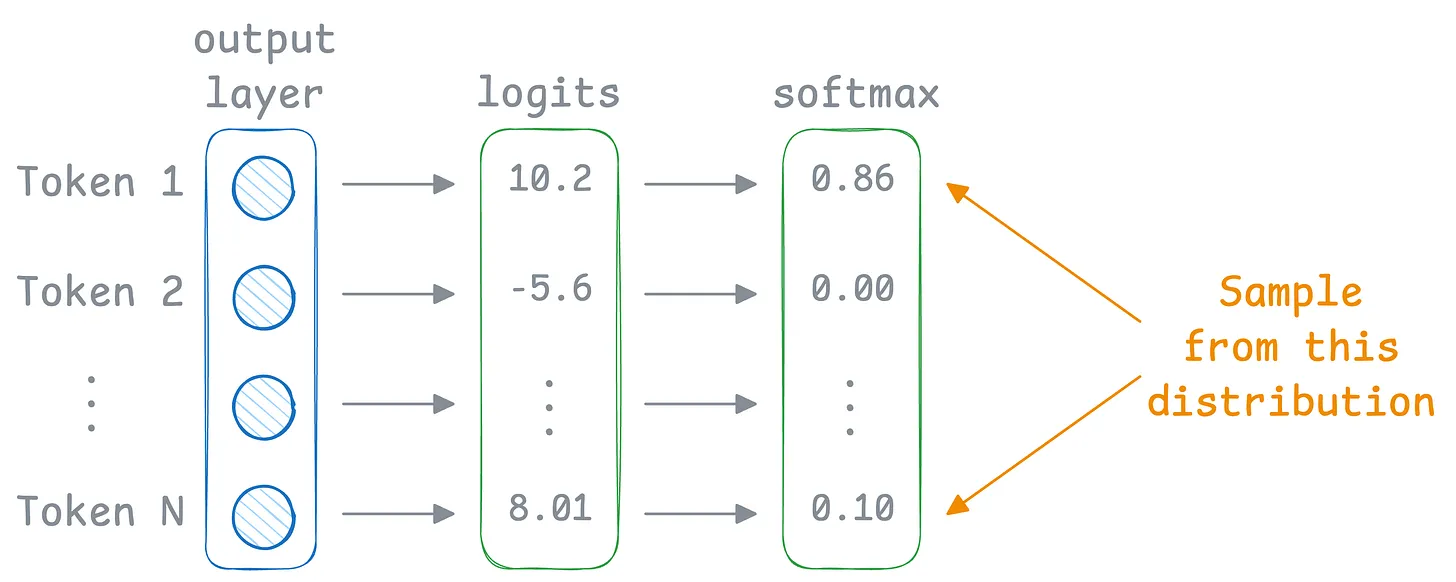

In [ ]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")


# **Temperature**

* Even though “Token 1” has the highest probability of being selected, it may not be chosen as the next token since we are sampling.

* **Temperature** introduces the following tweak in the softmax function, which, in turn, influences the sampling process:

  * If the **temperature is low**, the probabilities look more like a max value instead of a “**soft-max**” value.
  * If the **temperature is high**, the probabilities start to look like a **uniform distribution**, i.e., the sampling process may select any token. This makes the generation process random and heavily stochastic


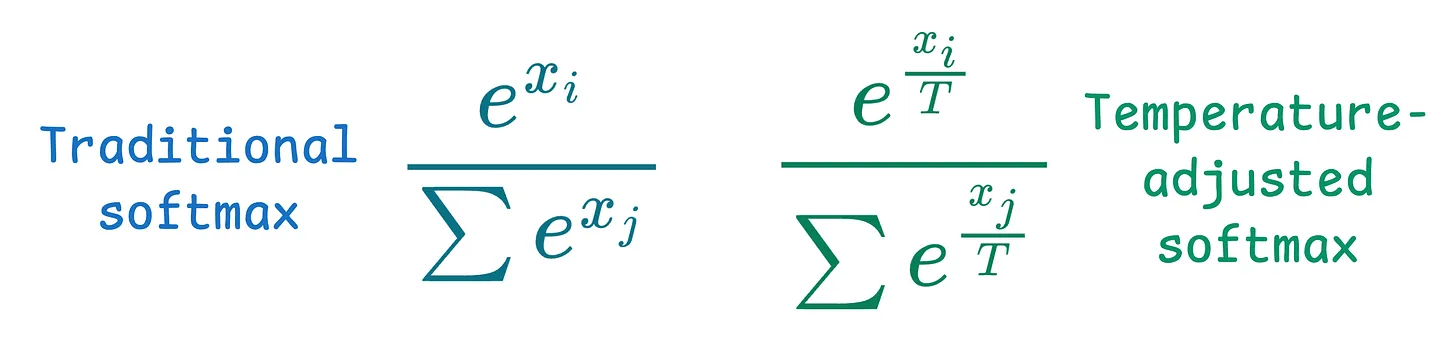

# **Sampling**

* **Greedy Search**: The token with the **highest probability** from the distribution will be selected as the next token.

* **Random Sampling**: Randomly selects the next token from the probability distribution. Two key concepts in random sampling are **top-k** and **top-p**.

 * **Top-k** limits the model to choosing a token randomly from only the top-k tokens with the highest probability. A top-k value equal to 1 acts as greedy search.

 * **Top-p** limits the model to randomly sampling from the set of tokens whose cumulative probabilities do not exceed a given threshold, starting from the highest probability and working downward.

 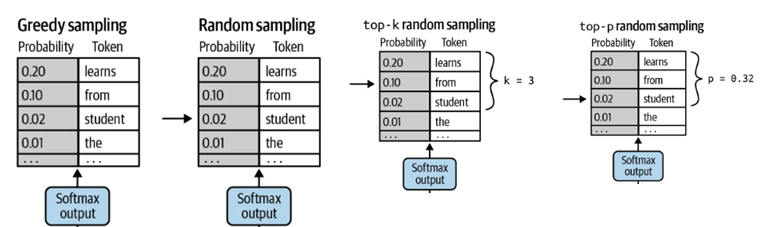


In [ ]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=0.1, top_k=40):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)


In [ ]:
# Full loop (generate multiple tokens)
# This section was actually utilized during the experimenting for the assignment on temperature value of 0.1

##### Temperature value of 0.1 - Conservative Behavior #####

# Function to test the temperature value of 0.1
def generate_step_by_step_01(prompt, steps=20):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]

            # top_k will remain at 40 for each trial but the temp will vary [0.1, 0.8, 2.0]
            next_token = sample_next_token(logits, temperature=0.1, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

print(f"Output with a temperature of 0.1 (Conservative) for prompt - \"{text}\":")

# 20 steps to generate 20 tokens
generate_step_by_step_01(text, steps=20)


In [ ]:
# Full loop (generate multiple tokens)
# This section was actually utilized during the experimenting for the assignment on temperature value of 0.8

##### Temperature value of 0.8 - Creative Behavior #####

# Function to test the temperature value of 0.8
def generate_step_by_step_08(prompt, steps=20):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]

            # top_k will remain at 40 for each trial but the temp will vary [0.1, 0.8, 2.0]
            next_token = sample_next_token(logits, temperature=0.8, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

print(f"Output with a temperature of 0.8 (Creative) for prompt - \"{text}\":")

# 20 steps to generate 20 tokens
generate_step_by_step_08(text, steps=20)


In [ ]:
# Full loop (generate multiple tokens)
# This section was actually utilized during the experimenting for the assignment on temperature value of 2.0

##### Temperature value of 2.0 - Chaotic Behavior #####

# Function to test the temperature value of 2.0
def generate_step_by_step_2(prompt, steps=20):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]

            # top_k will remain at 40 for each trial but the temp will vary [0.1, 0.8, 2.0]
            next_token = sample_next_token(logits, temperature=2.0, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

print(f"Output with a temperature of 2.0 (Chaotic) for prompt - \"{text}\":")

# 20 steps to generate 20 tokens
generate_step_by_step_2(text, steps=20)
